In [23]:
import yfinance as yf
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
def fetch_polygon_data(ticker, start_date, end_date, api_key):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{start_date}/{end_date}"
    params = {
        "adjusted": "true",
        "sort": "asc",
        "limit": 50000,
        "apiKey": "jg2eLsXS4qQz3_7Sm6ehprrEZNNfKVuT"
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    # See: https://polygon.io/docs/stocks/get_v2_aggs_ticker__stocksticker__range__multiplier___timespan___from___to
    if "results" not in data:
        raise ValueError(f"No results for {ticker}: {data}")
    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df = df.rename(columns={"t": "Date", "c": "Close", "o": "Open", "h": "High", "l": "Low", "v": "Volume"})
    df = df.set_index("Date")
    return df[["Open", "High", "Low", "Close", "Volume"]]

In [26]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN']
api_key = "jg2eLsXS4qQz3_7Sm6ehprrEZNNfKVuT"
start = "2023-01-01"
end = "2024-12-31"

In [31]:
all_prices = {}
for ticker in tickers:
    df = fetch_polygon_data(ticker, start, end, api_key)
    all_prices[ticker] = df["Close"]

prices = pd.DataFrame(all_prices)

In [33]:
#Calculate Daily Returns
def calc_returns(prices):
    return prices.pct_change().dropna()

In [34]:
#Calculate Beta Relative to Benchmark
def calc_betas(returns, benchmark):
    spy_returns = returns[benchmark]
    betas = {}
    for col in returns.columns:
        if col != benchmark:
            beta = returns[col].cov(spy_returns) / spy_returns.var()
            betas[col] = beta
    return betas

In [35]:
#Calculate Portfolio Metrics
def portfolio_metrics(returns, weights_dict, betas, benchmark, risk_free_rate=0.02):
    weights = np.array(list(weights_dict.values()))
    tickers = list(weights_dict.keys())
    
    # Portfolio return & std
    port_ret = (returns[tickers] @ weights).mean() * 252
    port_vol = (returns[tickers] @ weights).std() * np.sqrt(252)

    # Portfolio beta
    port_beta = sum(weights[i] * betas[tickers[i]] for i in range(len(tickers)))

    # Sharpe ratio
    sharpe = (port_ret - risk_free_rate) / port_vol

    return {
        "Annual Return": port_ret,
        "Annual Volatility": port_vol,
        "Sharpe Ratio": sharpe,
        "Portfolio Beta": port_beta
    }

In [36]:
#Simulate Random Portfolios for Efficient Frontier
def simulate_portfolios(returns, benchmark, n=1000, risk_free_rate=0.02):
    results = []
    tickers = [t for t in returns.columns if t != benchmark]

    for _ in range(n):
        weights = np.random.dirichlet(np.ones(len(tickers)))
        port_ret = (returns[tickers] @ weights).mean() * 252
        port_vol = (returns[tickers] @ weights).std() * np.sqrt(252)
        sharpe = (port_ret - risk_free_rate) / port_vol
        results.append({
            "Return": port_ret,
            "Volatility": port_vol,
            "Sharpe": sharpe,
            **{tickers[i]: weights[i] for i in range(len(tickers))}
        })
    
    return pd.DataFrame(results)

In [37]:
#Plot Efficient Frontier
def plot_frontier(df):
    sns.set_theme(style='darkgrid')
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Volatility', y='Return', hue='Sharpe', palette='viridis', legend=False)
    plt.title('Efficient Frontier')
    plt.xlabel('Annual Volatility (Risk)')
    plt.ylabel('Expected Annual Return')
    plt.show()

{'Annual Return': 0.29267388774295794, 'Annual Volatility': 0.2424953874558264, 'Sharpe Ratio': 1.1244497909991336, 'Portfolio Beta': 1.5066526771406807}


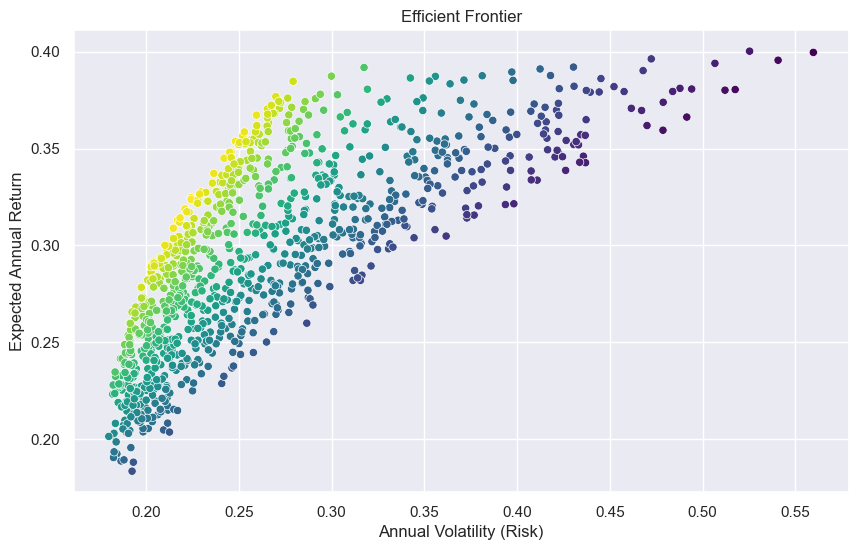

In [40]:
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'SPY']
start = '2023-01-01'
end = '2024-12-31'
api_key = "jg2eLsXS4qQz3_7Sm6ehprrEZNNfKVuT"

all_prices = {}
for ticker in tickers:
    df = fetch_polygon_data(ticker, start, end, api_key)
    all_prices[ticker] = df["Close"]

prices = pd.DataFrame(all_prices)

returns = calc_returns(prices)
betas = calc_betas(returns, 'SPY')

weights = {'AAPL': 0.25, 'MSFT': 0.25, 'TSLA': 0.25, 'AMZN': 0.25}
metrics = portfolio_metrics(returns, weights, betas, 'SPY')
print(metrics)

sim_df = simulate_portfolios(returns, 'SPY')
plot_frontier(sim_df)

## Next will be reworking and incorporating Google BigQuery so store ticker information for my longest time range to go back and grab to minimize API request